In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
from matplotlib import pyplot as plt

In [0]:
df = pd.read_csv('cust_matrix_int.csv')

In [0]:
df.head()

,cust_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,0,0,1,1,0,1,0,0,0,0,0
1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0
2,2,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0
3,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,-1,-1,0,0,0,0
4,4,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0


In [0]:
M = (np.array(df.iloc[:,1:]))

In [0]:
M.shape

(112589, 44)

In [0]:
idx=np.argwhere(M != 0)
values = M[M!=0]
values.shape

(647383,)

In [0]:
idx = tf.where(tf.not_equal(M, 0))
sparse_M = tf.SparseTensor(idx, values, M.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def tensor_to_numpy(tens):
  with tf.Session() as sess:
    return (tens.eval())

In [0]:
v = tensor_to_numpy(sparse_M.indices)

In [0]:
def sparse_mean_square_error(sparse_m, cust_embeddings, prod_embeddings):
  """
  Args:
    sparse_m: A SparseTensor rating matrix, of dense_shape [N, M]
    cust_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of customer i.
    prod_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of product j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions= tf.gather_nd(tf.matmul(cust_embeddings, prod_embeddings, transpose_b=True),
      sparse_m.indices)
  loss = tf.losses.mean_squared_error(sparse_m.values, predictions)
  return loss

In [0]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [0]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.AdamOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [0]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [ratings.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [ratings.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(ratings, U, V)
  metrics = {
      'train_error': train_loss,
  }
  embeddings = {
      "cust_id": U,
      "prod_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.847063

[{'train_error': 0.8470631}]

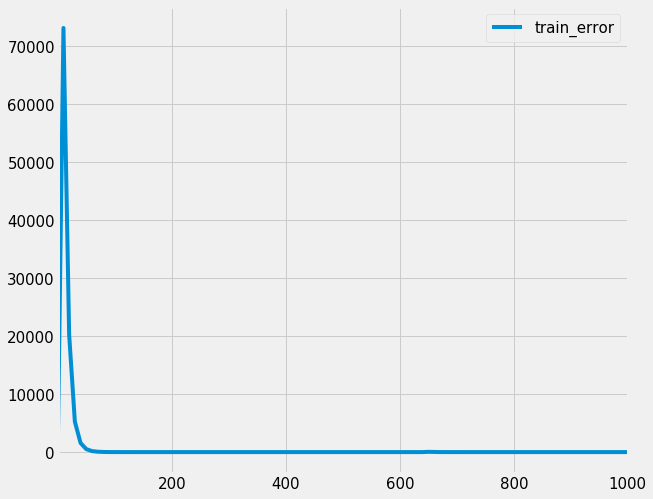

In [0]:
model = build_model(sparse_M, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [0]:
a = np.array([807.2511,  768.7781,  685.4434,  669.8684,  662.6182,  648.8273,  641.12976,
 618.08215, 615.4326,  615.0561 ])
b = np.array([9931, 106883, 107798, 34519, 74863, 111024, 90320, 19933, 8318, 24915])

In [0]:
x = pd.DataFrame({'Similarity Score': a, 'Customer ID': b})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

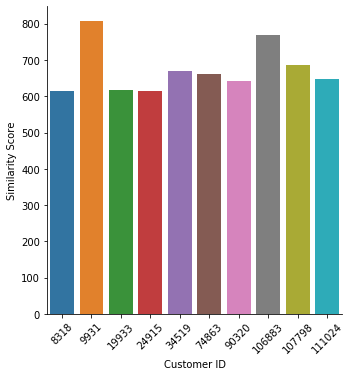

In [0]:
import seaborn as sns

sns.catplot(y = 'Similarity Score', x = 'Customer ID', data = x, kind = 'bar')
plt.xticks(rotation = 45)

In [0]:
sns.catplot(x = b, y = a)

In [0]:
emb = model.embeddings

In [0]:
cust_emb = emb['cust_id']
cust_emb.shape

(112589, 30)

In [0]:
prod_emb = emb['prod_id']
prod_emb.shape

(44, 30)

In [0]:
#[predictions for first customer]
pred = np.dot(cust_emb[19,:],prod_emb.T)

In [0]:
pred

array([-0.6685041 ,  0.27835247,  0.09060699,  0.07012698,  0.04733299,
        1.0936681 ,  0.20432295,  0.5410133 ,  0.65157443, -0.39778942,
       -0.08497767,  0.88420933, -0.25276494, -1.1893969 , -0.5408027 ,
       -0.39408433,  0.37388042, -0.05579899,  0.44301954,  0.45079038,
        0.03851806, -0.25038272, -0.09229919,  0.4192292 ,  2.7537985 ,
        0.22322318,  1.2328053 ,  0.2778355 ,  0.8019164 , -0.5214667 ,
        0.8870295 , -0.7434586 , -0.06287399, -0.8284562 , -0.33538872,
       -1.6749883 , -1.8506694 ,  0.10860839, -0.01276089, -0.49496552,
       -0.18937023,  0.96427214,  1.0609442 ,  0.8184343 ], dtype=float32)

In [0]:

def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  U = tf.Variable(tf.random_normal(
      [ratings.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [ratings.dense_shape[1], embedding_dim], stddev=init_stddev))
  # train_loss = sparse_mean_square_error(ratings, U, V)
  error_train = sparse_mean_square_error(ratings, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"cust_id": U, "prod_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

In [0]:
reg_model = build_regularized_model(
    sparse_M, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=1000, learning_rate=20.,plot_results=False)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
 iteration 1000: train_error_observed=0.596826, observed_loss=0.596826, regularization_loss=72.043961, gravity_loss=0.095179

[{'train_error_observed': 0.59682626},
 {'gravity_loss': 0.09517918,
  'observed_loss': 0.59682626,
  'regularization_loss': 72.04396}]

In [0]:
reg_emb = reg_model.embeddings

In [0]:
reg_cust_emb = reg_emb['cust_id']
reg_prod_emb = reg_emb['prod_id']

In [0]:
np.save('cust_emb.npy', reg_cust_emb)
np.save('prod_emb.npy', reg_prod_emb)

In [0]:
predicted_matrix = np.dot(cust_emb,prod_emb.T)

In [0]:
np.save('collab_matrix_output.npy',predicted_matrix)
predicted_matrix.shape

(112589, 44)

In [0]:
def find_similar_cust(cust_id,weights,n = 10, least = False, plot = False):
    
    try:
       
        dists = np.dot(weights, weights[cust_id-1,:])
    except KeyError:
        print(f'{cust_id} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    closest = sorted_dists[-n:]
    '''for c in reversed(closest):
      print(c,dists[c])'''
    return (dists,list(reversed(closest)))

In [0]:
cust_id = 27
dsts,indcs = find_similar_cust(cust_id,reg_cust_emb)
print('Similar customer ids to customer',cust_id, ' are\n', indcs)
print("Cosine Similarity Scores are :\n", dsts[indcs])

Similar customer ids to customer 27  are
 [9931, 106883, 107798, 34519, 74863, 111024, 90320, 19933, 8318, 24915]
Cosine Similarity Scores are :
 [807.2511  768.7781  685.4434  669.8684  662.6182  648.8273  641.12976
 618.08215 615.4326  615.0561 ]


In [0]:
from sklearn.manifold import TSNE
from umap import UMAP

In [0]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)
  

In [0]:
prod_r = reduce_dim(reg_prod_emb, components = 2, method = 'tsne')
prod_r.shape

(44, 2)

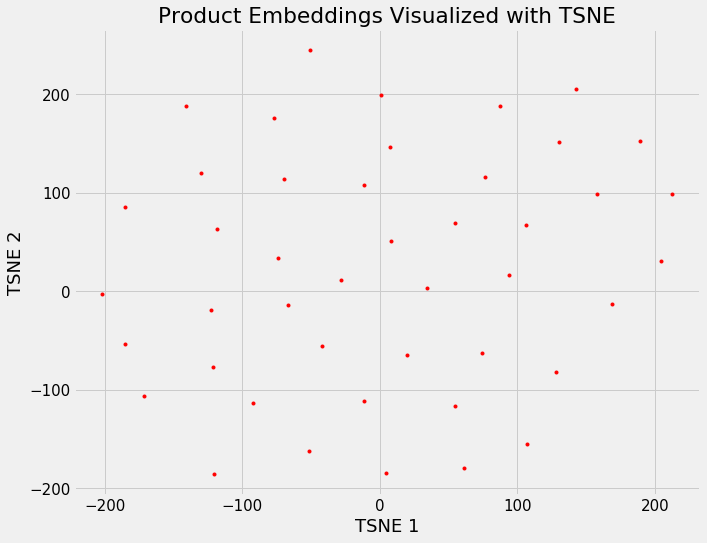

In [0]:
plt.figure(figsize = (10, 8))
plt.plot(prod_r[:, 0], prod_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Product Embeddings Visualized with TSNE');

In [0]:
def map_category(val):
  if val <8:
    return 'Entertainment'
  if val <13:
    return 'Food'
  if val <19:
    return 'Shopping'
  if val <24:
    return 'Banking'
  if val <29:
    return 'Travel'
  if val <35:
    return 'Lifestyle'
  if val <40:
    return 'Work'
  return 'Healthcare'


In [0]:
idx_include = []
categories = []

for i in range(44):
          idx_include.append(i)
          categories.append(map_category(i).capitalize())            
len(idx_include)

44

In [0]:
categories

['Entertainment',
 'Entertainment',
 'Entertainment',
 'Entertainment',
 'Entertainment',
 'Entertainment',
 'Entertainment',
 'Entertainment',
 'Food',
 'Food',
 'Food',
 'Food',
 'Food',
 'Shopping',
 'Shopping',
 'Shopping',
 'Shopping',
 'Shopping',
 'Shopping',
 'Banking',
 'Banking',
 'Banking',
 'Banking',
 'Banking',
 'Travel',
 'Travel',
 'Travel',
 'Travel',
 'Travel',
 'Lifestyle',
 'Lifestyle',
 'Lifestyle',
 'Lifestyle',
 'Lifestyle',
 'Lifestyle',
 'Work',
 'Work',
 'Work',
 'Work',
 'Work',
 'Healthcare',
 'Healthcare',
 'Healthcare',
 'Healthcare']

In [0]:
ints, cats = pd.factorize(categories)
cats.shape

(8,)

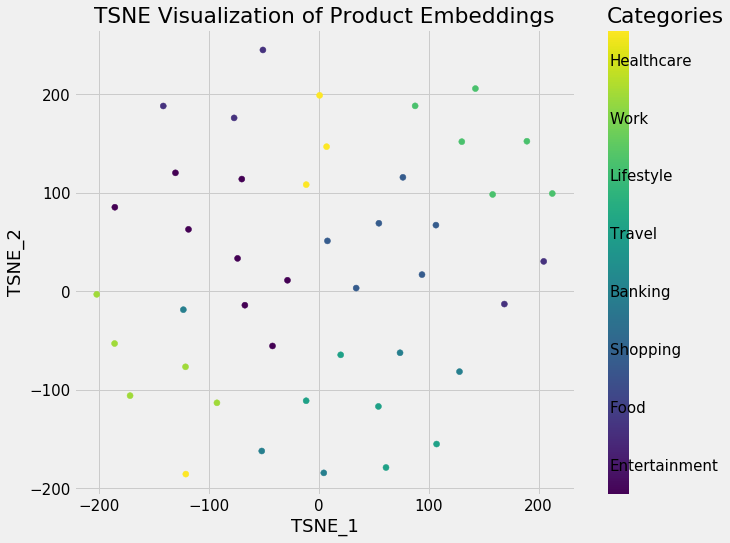

In [0]:
plt.figure(figsize = (10, 8))

# Plot embedding
colors = plt.cm.jet(np.linspace(0, 1, 8))
plt.scatter(prod_r[idx_include, 0],prod_r[idx_include, 1], 
            c = ints)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(cats):
    cbar.ax.text(1, (2 * j + 1) / ((1.15) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Categories', loc = 'left')


plt.xlabel('TSNE_1'); plt.ylabel('TSNE_2'); plt.title('TSNE Visualization of Product Embeddings');